## Variational Inference

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

In [1]:
import torch
import numpy as np
from gpytorch.optim import NGD
from torch.optim import Adam
from torch.nn import Parameter
from matplotlib import pyplot as plt

from alfi.datasets import ToyTranscriptomics, ToyTranscriptomicGenerator
from alfi.configuration import VariationalConfiguration
from alfi.models import TrainMode, generate_multioutput_rbf_gp
from alfi.plot import Plotter1d, Colours, tight_kwargs
from alfi.trainers import VariationalTrainer, PreEstimator
from alfi.utilities.data import p53_ground_truth

from experiments.variational import TranscriptionLFM

Let's start by importing our dataset...

C:\Users\Jacob\Documents\proj\lafomo\alfi\datasets\toy.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  basal = torch.tensor(ref.basal, dtype=self.dtype)
C:\Users\Jacob\Documents\proj\lafomo\alfi\datasets\toy.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  decay = torch.tensor(ref.decay, dtype=self.dtype)
C:\Users\Jacob\Documents\proj\lafomo\alfi\datasets\toy.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sensitivity = torch.tensor(ref.sensitivity, dtype=self.dtype)


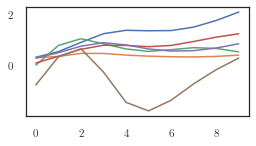

In [2]:
num_genes = 11
num_tfs = 3

dataset = ToyTranscriptomicGenerator(
    num_outputs=num_genes, num_latents=num_tfs, num_times=10, softplus=True, latent_data_present=True)
dataset.generate_single()

ground_truths = p53_ground_truth()
class ConstrainedTrainer(VariationalTrainer):
    def after_epoch(self):
        with torch.no_grad():
            sens = torch.tensor(1.)
            dec = torch.tensor(0.8)
            self.lfm.raw_sensitivity[3] = self.lfm.positivity.inverse_transform(sens)
            self.lfm.raw_decay[3] = self.lfm.positivity.inverse_transform(dec)
        super().after_epoch()


plt.figure(figsize=(4, 2))
for i in range(5):
    plt.plot(dataset[i][1])
plt.plot(dataset.f_observed[0, 0])
t_end = dataset.t_observed[-1]

We use the ordinary differential equation (ODE):

`dy/dt = b + sf(t) - dy`

`f(t) ~ GP(0, k(t, t'))`

Since this is an ODE, we inherit from the `OrdinaryLFM` class.

In [3]:
config = VariationalConfiguration(
    latent_data_present=True,
    num_samples=75,
    initial_conditions=False
)

num_inducing = 20  # (I x m x 1)
inducing_points = torch.linspace(0, t_end, num_inducing).repeat(num_tfs, 1).view(num_tfs, num_inducing, 1)
t_predict = torch.linspace(0, t_end+2, 80, dtype=torch.float32)
step_size = 5e-1
num_training = dataset.m_observed.shape[-1]
use_natural = True
gp_model = generate_multioutput_rbf_gp(num_tfs, inducing_points, gp_kwargs=dict(natural=use_natural))


from alfi.utilities.torch import softplus
class SoftplusTranscriptionLFM(TranscriptionLFM):
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration, **kwargs):
        super().__init__(num_outputs, gp_model, config, **kwargs)
        num_latents = gp_model.variational_strategy.num_tasks
        # self.sensitivity = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float32))
        self.weight = Parameter(0.5 * torch.randn(torch.Size([self.num_outputs, num_latents]), dtype=torch.float32))
        self.weight_bias = Parameter(torch.randn(torch.Size([self.num_outputs, 1]), dtype=torch.float32))

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)
        # print(t, self.t_index)
        # print(self.f.shape)
        decay = self.decay_rate * h
        f = self.f[:, :, self.t_index].unsqueeze(2)
        h = self.basal_rate + f - decay
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t
        return h

    def nonlinearity(self, f):
        return softplus(f)

    def mix(self, f):
        interactions = torch.matmul(self.weight, torch.log(f+1e-100)) + self.weight_bias
        f = torch.sigmoid(interactions) # TF Activation Function (sigmoid)
        return f

lfm = SoftplusTranscriptionLFM(num_genes, gp_model, config, num_training_points=num_training)
plotter = Plotter1d(lfm, dataset.gene_names, style='seaborn')

In [4]:
track_parameters = [
    'raw_basal',
    'raw_decay',
    'raw_sensitivity',
    'gp_model.covar_module.raw_lengthscale',
]
if use_natural:
    variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.09)
    parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.02)
    optimizers = [variational_optimizer, parameter_optimizer]
    pre_variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
    pre_parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.005)
    pre_optimizers = [pre_variational_optimizer, pre_parameter_optimizer]

else:
    optimizers = [Adam(lfm.parameters(), lr=0.05)]
    pre_optimizers = [Adam(lfm.parameters(), lr=0.05)]

trainer = ConstrainedTrainer(lfm, optimizers, dataset, track_parameters=track_parameters)
pre_estimator = PreEstimator(lfm, pre_optimizers, dataset, track_parameters=track_parameters)

### Outputs prior to training:

torch.Size([80, 14])


Text(0.5, 1.0, 'Latent')

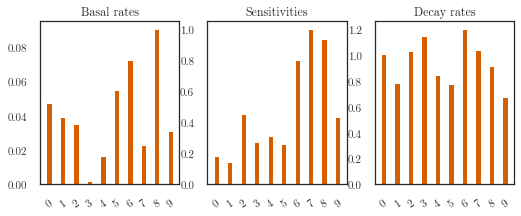

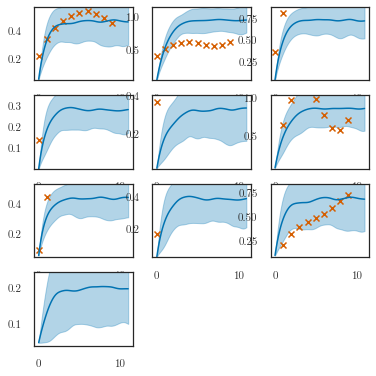

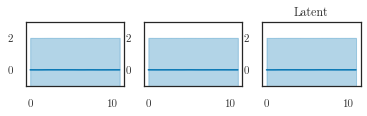

In [5]:
titles = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['raw_basal', 'raw_sensitivity', 'raw_decay']:
    kinetics.append(
        lfm.positivity.transform(trainer.parameter_trace[key][-1].squeeze()).numpy())
kinetics = np.array(kinetics)

plotter.plot_double_bar(kinetics,
                        # ground_truths=p53_ground_truth(),
                        titles=titles)
q_m = lfm.predict_m(t_predict, step_size=1e-1)
q_f = lfm.predict_f(t_predict)
print(q_m.mean.shape)
plotter.plot_gp(q_m, t_predict, replicate=0,
                t_scatter=dataset.t_observed,
                y_scatter=dataset.m_observed, num_samples=0)
plotter.plot_gp(q_f, t_predict, ylim=(-1, 3))
plt.title('Latent')

In [6]:
lfm.set_mode(TrainMode.GRADIENT_MATCH)
# lfm.loss_fn.num_data = 61
# pre_estimator.train(50, report_interval=20);

In [11]:
lfm.set_mode(TrainMode.NORMAL)
lfm.loss_fn.num_data = num_training
trainer.train(100, report_interval=10, step_size=step_size);

Epoch 201/300 - Loss: -9.27 (-11.49 2.22) kernel: [2.0480907 2.395163  4.2380986]
Epoch 211/300 - Loss: -10.57 (-12.92 2.35) kernel: [2.0821002 2.409875  4.404466 ]
Epoch 221/300 - Loss: -11.81 (-14.29 2.48) kernel: [2.0890656 2.4176679 4.564143 ]
Epoch 231/300 - Loss: -13.06 (-15.68 2.62) kernel: [2.084852 2.405932 4.715557]
Epoch 241/300 - Loss: -14.26 (-17.01 2.74) kernel: [2.10349   2.4136884 4.8578496]
Epoch 251/300 - Loss: -15.54 (-18.41 2.87) kernel: [2.102957 2.424108 4.98224 ]
Epoch 261/300 - Loss: -16.73 (-19.73 3.01) kernel: [2.1143122 2.42749   5.0855794]
Epoch 271/300 - Loss: -17.81 (-20.94 3.13) kernel: [2.1222496 2.4055974 5.193232 ]
Epoch 281/300 - Loss: -18.96 (-22.23 3.26) kernel: [2.1224434 2.421767  5.3056254]
Epoch 291/300 - Loss: -20.04 (-23.43 3.38) kernel: [2.116009  2.4230254 5.4046993]


MultitaskMultivariateNormal(loc: torch.Size([240]))

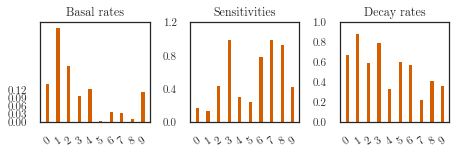

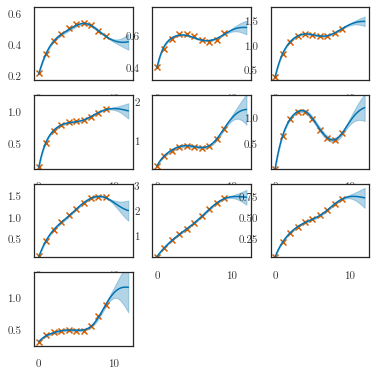

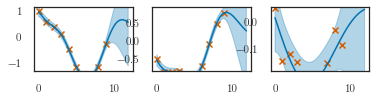

In [12]:
t_predict = torch.linspace(0, t_end+3, 80, dtype=torch.float32)

# plotter.plot_losses(trainer, last_x=200)
q_m = lfm.predict_m(t_predict, step_size=1e-1)
q_f = lfm.predict_f(t_predict)


titles = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['raw_basal', 'raw_sensitivity', 'raw_decay']:
    kinetics.append(
        lfm.positivity.transform(trainer.parameter_trace[key][-1].squeeze()).numpy())
kinetics = np.array(kinetics)
plotter.plot_double_bar(kinetics,
                        titles=titles,
                        figsize=(6.5, 2.3),
                        yticks=[
                            np.linspace(0, 0.12, 5),
                            np.linspace(0, 1.2, 4),
                            np.arange(0, 1.1, 0.2),
                        ])


plt.tight_layout()
# plt.savefig('./kinetics.pdf', **tight_kwargs)

plotter.plot_gp(q_m, t_predict,
                t_scatter=dataset.t_observed, y_scatter=dataset.m_observed)
plotter.plot_gp(q_f, t_predict, t_scatter=dataset.t_observed, y_scatter=dataset.f_observed)